In [133]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import math

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder
import hdf5storage as hs
from sklearn.linear_model import LinearRegression
from Neural_Decoding.decoders import LSTMDecoder

In [116]:
fp = './indy_20161005_06.mat'
mat = hs.loadmat(fp)

channels = mat['chan_names']
cursor_pos = mat['cursor_pos']
finger_pos = mat['finger_pos']
target_pos = mat['target_pos']
timestamp = mat['t'].squeeze(1)
spikes = mat['spikes']
finger_pos_x = finger_pos[:, 1]
finger_pos_y = finger_pos[:, 2]
print(finger_pos_x)

[0.75696101 0.75742583 0.75791599 ... 2.62262089 2.621249   2.62017112]


In [117]:
#将脉冲采样时间与位置采样时间对应
print(finger_pos.shape[0])
time_stamp_num = finger_pos.shape[0]
#整合所有神经元脉冲时间，脉冲次数低于500的不算神经元unit
unit_count = 0
spikes_data = []
for ch_index in range(0,spikes.shape[0]):
    for unit_index in range(1,5):
        if spikes[ch_index][unit_index].shape[0]>=500:
            unit_count+=1
            spike_data = [0]*time_stamp_num
            for spike_index in range(0,spikes[ch_index][unit_index].shape[0]):
                if(float(spikes[ch_index][unit_index][spike_index])>=1288 and float(spikes[ch_index][unit_index][spike_index])<=1662):
                    spike_data[round((float(spikes[ch_index][unit_index][spike_index])-1288)/0.004)]=1
            spikes_data.append(spike_data)
spikes_data = np.array(spikes_data).T
print(spikes_data.shape)

93501


C:\Users\s\AppData\Local\Temp\ipykernel_21948\1304422309.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if(float(spikes[ch_index][unit_index][spike_index])>=1288 and float(spikes[ch_index][unit_index][spike_index])<=1662):
C:\Users\s\AppData\Local\Temp\ipykernel_21948\1304422309.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  spike_data[round((float(spikes[ch_index][unit_index][spike_index])-1288)/0.004)]=1


(93501, 95)


In [118]:
#计算速度数据
vel_data = []
for i in range(0,finger_pos.shape[0]-1):
    cur_vx = (finger_pos[i+1][1]-finger_pos[i][1])/0.004
    cur_vy = (finger_pos[i+1][2]-finger_pos[i][2])/0.004
    vel_data.append([cur_vx,cur_vy])
vel_data.append([0,0])
vel_data = np.array(vel_data)
print(vel_data.shape)

(93501, 2)


In [119]:
lag =0

In [120]:
#The covariate is simply the matrix of firing rates for all neurons over time
X_kf=spikes_data

In [121]:
#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of velocity (for this dataset)
#But using them all as covariates helps performance

#We will now determine position
pos_binned=np.zeros(vel_data.shape) #Initialize 
pos_binned[0,:]=0 #Assume starting position is at [0,0]
#Loop through time bins and determine positions based on the velocities
for i in range(pos_binned.shape[0]-1): 
    pos_binned[i+1,0]=pos_binned[i,0]+vel_data[i,0]*0.004 #Note that .05 is the length of the time bin
    pos_binned[i+1,1]=pos_binned[i,1]+vel_data[i,1]*0.004
print(pos_binned.shape)
#We will now determine acceleration    
temp=np.diff(vel_data,axis=0) #The acceleration is the difference in velocities across time bins 
acc_binned=np.concatenate((temp,temp[-1:,:]),axis=0) #Assume acceleration at last time point is same as 2nd to last

#The final output covariates include position, velocity, and acceleration
y_kf=np.concatenate((pos_binned,vel_data,acc_binned),axis=1)

(93501, 2)


In [122]:
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

In [123]:
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

In [124]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(int(np.round(training_range[0]*num_examples_kf))+1,int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(int(np.round(testing_range[0]*num_examples_kf))+1,int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(int(np.round(valid_range[0]*num_examples_kf))+1,int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]


In [125]:
#Z-score inputs 
X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)
X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

#Zero-center outputs
y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
y_kf_test=y_kf_test-y_kf_train_mean
y_kf_valid=y_kf_valid-y_kf_train_mean

In [126]:
#Declare model
model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf[2:4]) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf[2:4]**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

R2: [0.10905413 0.26001197]
rho2: [0.16081662 0.26039677]


Text(0.5, 1.0, 'vx decoding(Kalman Filter)')

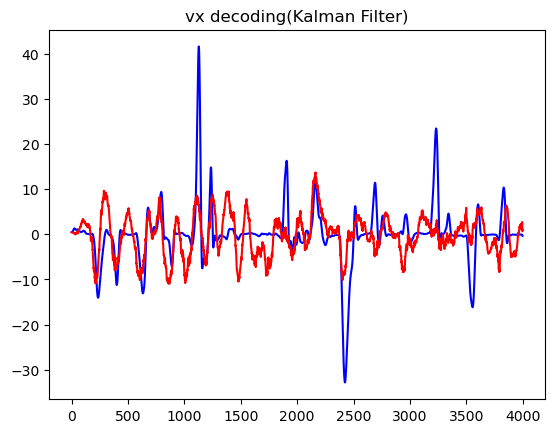

In [127]:
#As an example, I plot an example 1000 values of the x velocity (column index 2), both true and predicted with the Kalman filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[:4000,2]+y_kf_train_mean[2],'b')
plt.plot(y_valid_predicted_kf[:4000,2]+y_kf_train_mean[2],'r')
plt.title("vx decoding(Kalman Filter)")
#Save figure
# fig_x_kf.savefig('x_velocity_decoding.eps')

In [128]:
#线性回归
#Declare model
model_linear=LinearRegression()
#Fit model
model_linear.fit(X_kf_train,y_kf_train)

#Get predictions
y_valid_predicted_linear=model_linear.predict(X_kf_valid)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_linear=get_R2(y_kf_valid,y_valid_predicted_linear)
print('R2:',R2_linear[2:4]) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_linear=get_rho(y_kf_valid,y_valid_predicted_linear)
print('rho2:',rho_linear[2:4]**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

R2: [0.01045482 0.03120861]
rho2: [0.01245792 0.03200195]


Text(0.5, 1.0, 'vx decoding(Linear Regression)')

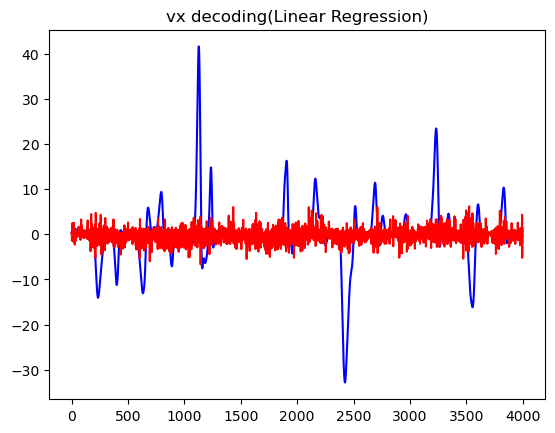

In [129]:
fig_x_linear=plt.figure()
plt.plot(y_kf_valid[:4000,2]+y_kf_train_mean[2],'b')
plt.plot(y_valid_predicted_linear[:4000,2]+y_kf_train_mean[2],'r')
plt.title("vx decoding(Linear Regression)")
